In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [360]:
trace_ID_1 = 1 # 1, 1.5
trace_ID_2 = 2 # -1, -1.5

In [361]:
def read_trace(id):
    file_path = f'../data/{id}/trace.plk'
    df = pd.read_pickle(file_path)
    return df

trace_1=read_trace(trace_ID_1)
trace_2=read_trace(trace_ID_2)


([<matplotlib.axis.XTick at 0x7f74ef465fd0>,
 [Text(0, 0, '0'),
  Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3')])

<Figure size 500x200 with 0 Axes>

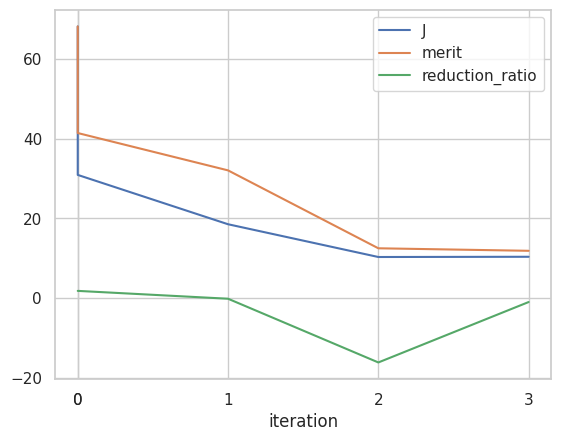

In [362]:
plt.figure(figsize=(5, 2))
trace_1.plot(x='iteration', y=['J', 'merit', 'reduction_ratio'], kind='line')
plt.xticks(trace_1['iteration']) 

<Axes: xlabel='iteration'>

<Figure size 500x200 with 0 Axes>

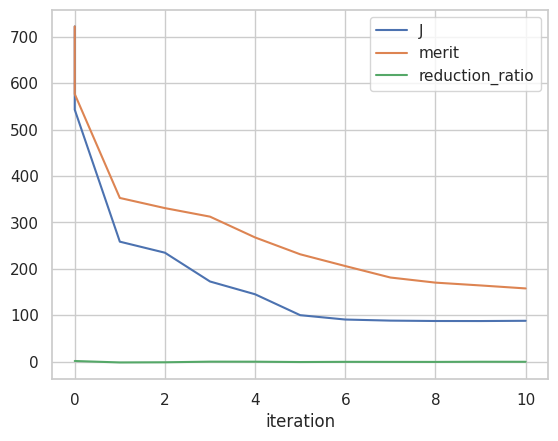

In [363]:
plt.figure(figsize=(5, 2))
trace_2.plot(x='iteration', y=['J', 'merit', 'reduction_ratio'], kind='line')


Plot the error at each iteration

In [364]:
def get_dx_from_file(id):
    df = pd.read_pickle(f'../data/{id}/dx.plk')
    df['dx']=df['value'].apply(lambda x: np.abs(x[0]))
    df['dy']=df['value'].apply(lambda x: np.abs(x[1]))
    df['vx']=df['value'].apply(lambda x: np.abs(x[2]))
    df['vy']=df['value'].apply(lambda x: np.abs(x[3]))
    df['norm']=np.sqrt(df['dx']**2 + df['dy']**2 + df['vx']**2  + df['vy']**2 )
    df=df.drop(columns=['value'])

    return df

def plot_error(df):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(df['dx'], marker='o', linestyle='-', color='green')
    ax1.grid(True)
    ax1.set_title('Norm of the end effector error over time')
    ax1.set_xticklabels([])


    ax2 = ax1.twiny()
    unique_iterations = df['iteration'].unique()
    tick_positions = [df[df['iteration'] == iteration].index[0] for iteration in unique_iterations]
    tick_labels = unique_iterations
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels)
    ax2.set_xlabel('Iteration')
    ax2.set_position([ax1.get_position().x0, 0.1, ax1.get_position().width, ax1.get_position().height])


    ax3 = ax2.twiny()
    unique__line_iterations = df['line_search_iteration'].unique()
    tick_positions = [df[df['line_search_iteration'] == iteration].index[0] for iteration in unique__line_iterations]
    tick_labels = unique__line_iterations
    ax3.set_xticks(tick_positions)
    ax3.set_xticklabels(tick_labels)
    ax3.set_xlabel('Line Search Iteration')
    ax3.set_position([ax1.get_position().x0, 0.1, ax1.get_position().width, ax1.get_position().height-1.5])

   
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_iterations)))

    for i, iteration in enumerate(unique_iterations):
        mask = df['iteration'] == iteration
        ax1.axvspan(df.index[mask].min(), df.index[mask].max(), color=colors[i], alpha=0.3)

    plt.show()

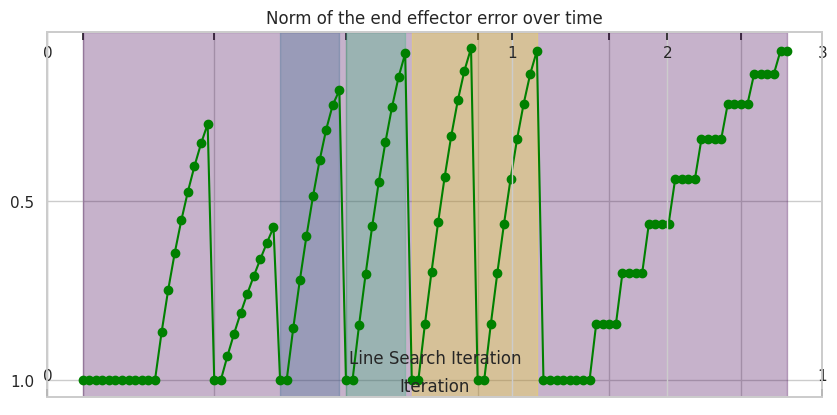

In [365]:
error_1 = get_dx_from_file(trace_ID_1)
plot_error(error_1)

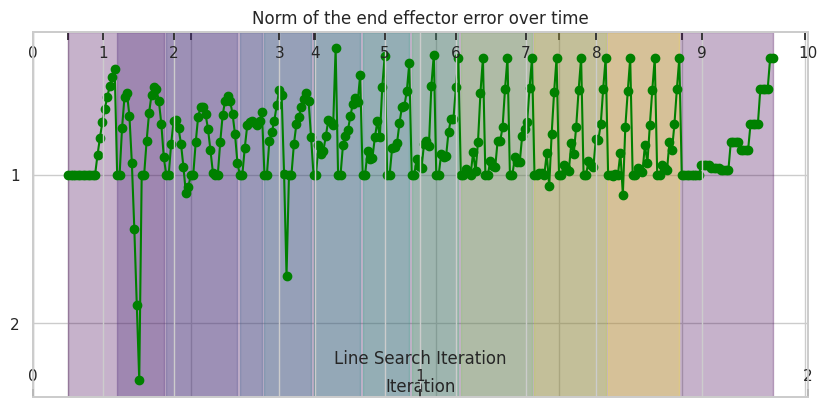

In [366]:
error_2 = get_dx_from_file(trace_ID_2)
plot_error(error_2)

### Inner traces

In [367]:
def get_inner_traces_from_file(id):
    df = pd.read_pickle(f'../data/{id}/inner_traces.plk')
    df['Iteration']=df[1]
    df['Outer Iteration']=df[2]
    df['r']=df[0].apply(lambda x: x[0])
    df['error']=df[0].apply(lambda x: x[1])
    df['PCG_iteration']=df['r'].apply(lambda x: len(x))
    df=df.drop(columns=[0,1,2])
    return df

def plot_inner_trace(df, iteration):
    plt.figure(figsize=(10, 5))
    trace=df[df['Iteration']==iteration]
    r=trace['r'].values[0]
    error=trace['error'].values[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(r, marker='o', linestyle='-', color='green')
    ax1.set_title('residual: b-Ax')
    ax1.grid(True)

    ax2.plot(error, marker='o', linestyle='-', color='red')
    ax2.set_title('Error')
    ax2.grid(True)

    fig.suptitle(f'Inner Trace of QP solve number {iteration}', fontsize=16)

    plt.tight_layout


<Figure size 1000x500 with 0 Axes>

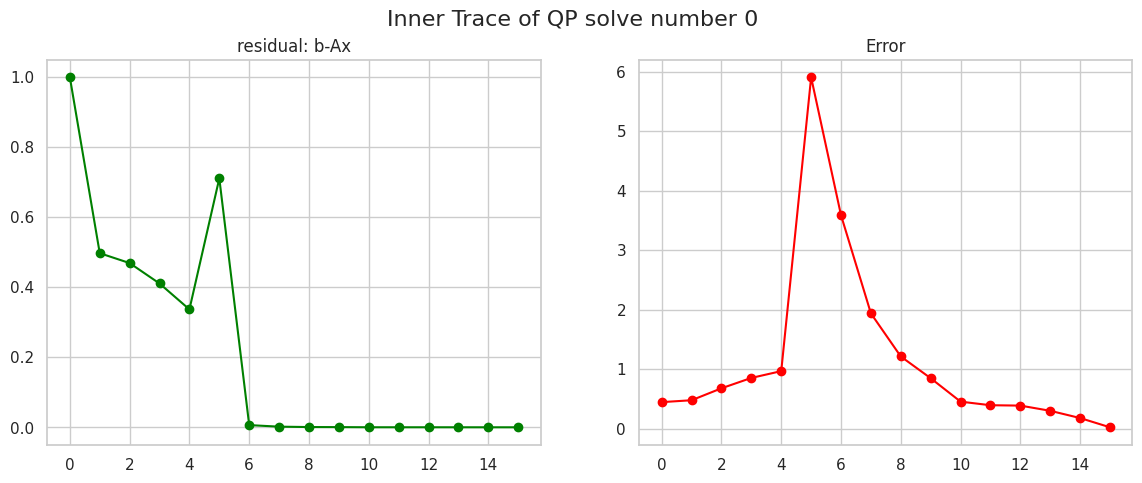

In [368]:
inner_traces_1= get_inner_traces_from_file(trace_ID_1)
plot_inner_trace(inner_traces_1,0)

<Figure size 1000x500 with 0 Axes>

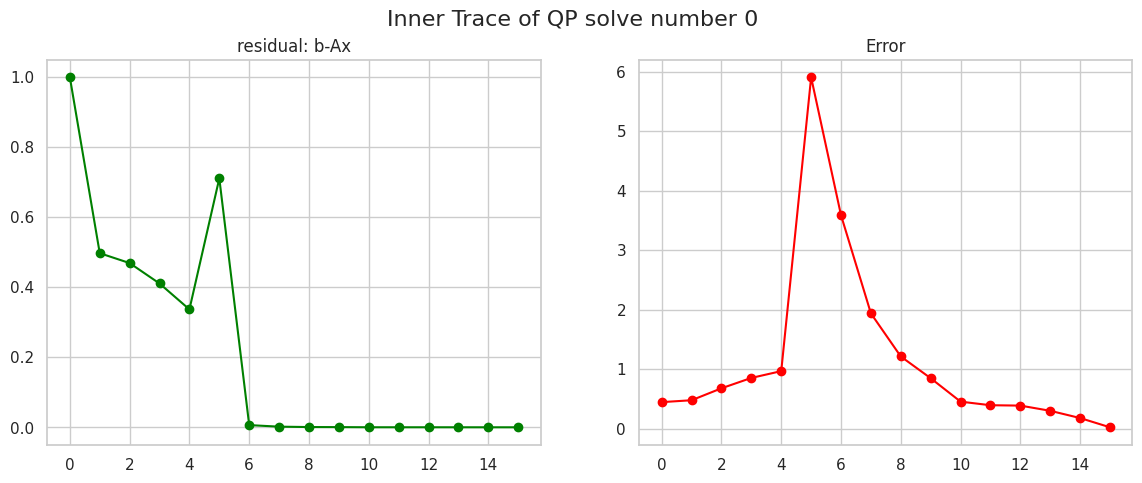

In [369]:
inner_traces_2= get_inner_traces_from_file(trace_ID_2)
plot_inner_trace(inner_traces_2,0)

### Compare Final trajectory results

In [370]:
def get_results_from_file(id):
    df = pd.read_pickle(f'../data/{id}/results.plk')
    df = df.transpose()
    column_names = ['comp_time', 'J', 'Jx', 'Ju', 'error', 'E', 'exit_sqp', 'exit_soft', 'outer_iter', 'sqp_iter']
    df.columns = column_names
    df['Error in x']= df["error"].apply(lambda x: np.abs(x[0]))
    df['Error in y']= df["error"].apply(lambda x: np.abs(x[0]))
    df['Error Norm']=np.sqrt(df['Error in x']**2 + df['Error in y']**2 )
    df['Soft Constraint exit condition']=df['exit_soft'].map({0: 'No exit', 1: 'Convergence', 2: 'Max Iters', 3: 'Mu over limit for all soft constraints'})
    df['QP Solve exit condition']=df['exit_sqp'].map({0: 'No exit', 1: 'Convergence', 2: 'Max rho', 3: 'Max Iters'})
    df = df.rename(columns={'outer_iter': 'Soft constraint Loop iterations', 'sqp_iter': 'QP Solve Loop iterations'}).drop(columns=['exit_sqp', 'exit_soft'])
    return df

def plot_results(df):

    rows_to_compare = ['J', 'Jx', 'Ju', 'E', 'Error Norm']
    df=df[rows_to_compare]
    results_1 = df[rows_to_compare].iloc[0]
    results_2 = df[rows_to_compare].iloc[1]
    fig, axs = plt.subplots(nrows=2, ncols=3, sharey=False)
    axs=axs.flatten()
    bar_width = 0.35
    for i, col in enumerate(df.columns):
        sns.barplot(x=['Trace 1', 'Trace 2'], y=[results_1[col], results_2[col]], ax=axs[i])
        # axs[i].bar([0, 1], [results_1[col], results_2[col]], bar_width, color=['blue', 'red'], edgecolor='black')
        axs[i].set_title(col)
        # axs[i].set_xticks([0, 1])
        # axs[i].set_xticklabels(['Trace 1', 'Trace 2'])
    fig.text(0.5, 0.04, 'Rows', ha='center')
    fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical')
    plt.suptitle('Final Trajectory Results')
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
plt.show()

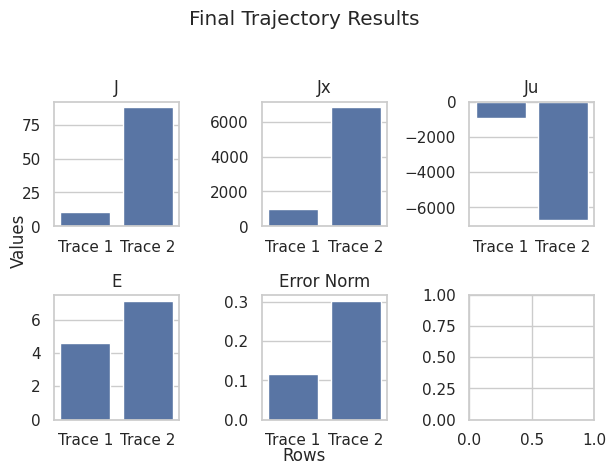

In [371]:
results_1=get_results_from_file(trace_ID_1)
results_2=get_results_from_file(trace_ID_2)
results=pd.concat((results_1,results_2)).reset_index().drop(columns='index')
plot_results(results)